# Imports

In [2]:
from sklearn.neighbors import LocalOutlierFactor # not used
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from sklearn import tree
from scipy.io import arff
from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import struct # not used
import graphviz
import math

# Definitions

In [2]:
def k_mean(K, dataset, title="K-Mean Cluster Plot", xLabel=None, yLabel=None, NonZero=None):
    """
    Performs K clusters with K-mean on the given dataset and shows the scatter plot afterwards.
    
    @param int K: number of clusters
    @param DataFrame dataset: dataframe of the data to perform k-mean on
    @param str title: what the title of the plot is.
    """
    if NonZero == None:
        dataset = dataset[dataset != 0].dropna()
    else:
        for i in NonZero:
            dataset = dataset[dataset[i] != 0].dropna()
        
    k_model = KMeans(n_clusters=K)       # get new kmean model with number of clusters = K
    k_model.fit(dataset)                 # fit the data set with the model
    y_pred = k_model.predict(dataset)    # get y predictor from the dataset
    centroids = k_model.cluster_centers_ # get the centroids
    for i in centroids:
        print(i)
    
    %matplotlib inline
    plt.rcParams.update({'font.size': 16})
#     plt.figure(figsize=(5,5))                                                       # set figure size to (12,12)
    plt.scatter(dataset.iloc[:,0], dataset.iloc[:,1], marker='o', alpha=1, c=y_pred)  # scatter data points
    plt.scatter(centroids[:,0], centroids[:,1], marker='*', s=200, linewidths=2, color='r', alpha=.4)      # scatter centoids
    plt.xlabel(dataset.columns.values[0] if xLabel==None else xLabel)                 # set x-axis label
    plt.ylabel(dataset.columns.values[1] if yLabel==None else yLabel)                 # set y-axis label
    plt.title(title)                                                                  # set title
    plt.show()                                                                        # show plot

In [53]:
def k_mean3D(K, dataset, title="K-Mean Cluster 3D Plot", xLabel=None, yLabel=None, zLabel=None):
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111, projection='3d')
    
    
    k_model = KMeans(n_clusters=K)
    k_model.fit(dataset)
    y_pred = k_model.predict(dataset)
    centroids = k_model.cluster_centers_
    
    plt.rcParams.update({'font.size':16})
    ax.scatter(dataset.iloc[:,0], dataset.iloc[:,1], dataset.iloc[:,2], marker='o', c=y_pred)
    ax.scatter(centroids[:,0], centroids[:,1], centroids[:,2], marker='x', s=200, linewidths=2)
    ax.set_xlabel(dataset.columns.values[0] if xLabel==None else xLabel, labelpad=14, fontsize=13, color='b')
    ax.set_ylabel(dataset.columns.values[1] if yLabel==None else yLabel, labelpad=14, fontsize=13, color='g')
    ax.set_zlabel(dataset.columns.values[2] if zLabel==None else zLabel, labelpad=14, fontsize=13, color='r')
    ax
    
    plt.title(title)
    plt.show()

In [59]:
def k_nn(dataset, label, title="K-Near Neighbor", yLabel=None, Class='class'):
    """
    Perform K-NN on the given dataset with a target and the given label for data.
    
    @param DataFrame dataset: dataframe of the data to perform K-NN on.
    @param str target: what column is the target variable in the dataset.
    @param str label: what column is the label in the dataset.
    """
    a = dataset[dataset != 'anomaly'].dropna().drop([Class], axis=1)
    n = dataset[dataset != 'normal'].dropna().drop([Class, label], axis=1)
    df = dataset[dataset!=0].dropna().drop([label, Class], axis=1)               # get dataset without label
    
    knn = KNeighborsClassifier(n_neighbors = 3)
#     xTrain, xTest, yTrain, yTest = train_test_split(df, dataset[label], test_size = 0.3, random_state=42)
    knn.fit(a.drop([label],axis=1), a[label])
    yPred = knn.predict(df)
    
    labels, counts = np.unique(yPred, return_counts=True)
    percents = []
    _sum = sum(counts)
    for i in counts:            
        percents.append(i/_sum)
        
    
    %matplotlib inline
    plt.rcParams.update({'font.size': 20})
#     plt.figure(figsize=(8, 8))
    plt.pie(percents, labels=labels, autopct='%1.1f%%')
    plt.title(title)
    plt.show()

In [5]:
def decision_tree(dataset, target, label, title="Decision Tree"):
    df = dataset.drop([label], axis=1)
    var = tree.DecisionTreeClassifier()
    var = var.fit(df[:13], df[target][:13])
    
    dot_data = tree.export_graphviz(var, out_file=None, 
                                    feature_names=df.columns,
                                    class_names=dataset[label],  
                                    filled=True, rounded=True,
                                    special_characters=True)  
    graph = graphviz.Source(dot_data)  
    return graph

In [6]:
# decision_tree(kddDF[['src_bytes','count', 'Class']], "src_bytes", "Class", "DoS")

In [7]:
def swarm_all(dataset, X, title = "Swarm Plot"):
    df = dataset.drop([X], axis=1)
    for i in df.columns:
        plt.rcParams.update({'font.size': 20})
        sns.swarmplot(x=X, y=i, data=dataset)
        plt.title(title)
        plt.show()

In [8]:
def plot_all(dataset, X, title="Scatter Plot", xLabel=None, yLabel=None):
    df = dataset.drop([X], axis=1)
    dataset = dataset[dataset != 0].dropna()
    
    a = dataset[dataset != 'normal'].dropna()
    n = dataset[dataset != 'anomaly'].dropna()

    #%matplotlib inline
    for i in df.columns:
        plt.figure(figsize=(12, 12))
        plt.rcParams.update({'font.size': 16})
        plt.plot(a.index.values.tolist(), a[i], '-x', color='r')
        plt.plot(n.index.values.tolist(), n[i], '-o', color='g')
        plt.xlabel("Row Number" if xLabel==None else xLabel)
        plt.ylabel(i if yLabel==None else yLabel)
        
        plt.legend(np.unique(dataset[X]))
        plt.title(title)
    plt.show()

In [5]:
def find_k_graph(kTests, data, title="Selecting K with the Elbow Method"):
    # k-means cluster analysis
    clusters=range(1,kTests+1)
    meandist=[]
    
    for k in clusters:
        model=KMeans(n_clusters=k)
        model.fit(data)
        clusassign=model.predict(data)
        meandist.append(sum(np.min(cdist(data, model.cluster_centers_, 'euclidean'), axis=1)) / data.shape[0])
    # Identify number of clusters
    plt.rcParams.update({'font.size': 16})
    plt.plot(clusters, meandist)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average distance')
    plt.show()

# NSL-KDD Dataset

<u><strong>Load NSL-KDD dataset<strong></u>

In [4]:
kddFile = arff.loadarff('KDDTrain+.arff')
kddDF = pd.DataFrame(kddFile[0])
for i in kddDF.columns:
    if type(kddDF[i][0]) == bytes:
        kddDF[i] = kddDF[i].str.decode('utf-8')
kddDF.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0.0,tcp,ftp_data,SF,491.0,0.0,0,0.0,0.0,0.0,...,25.0,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0.0,udp,other,SF,146.0,0.0,0,0.0,0.0,0.0,...,1.0,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,26.0,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0.0,tcp,http,SF,232.0,8153.0,0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0.0,tcp,http,SF,199.0,420.0,0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [11]:
kddDF.describe()

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,125973.00000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,...,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,4.556674e+04,1.977911e+04,0.022687,0.000111,0.204409,0.001222,0.279250,0.001342,0.001103,...,182.148945,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240
std,2604.51531,5.870331e+06,4.021269e+06,0.253530,0.014366,2.149968,0.045239,23.942042,0.036603,0.045154,...,99.206213,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459
min,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.00000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42908.00000,1.379964e+09,1.309937e+09,3.000000,3.000000,77.000000,5.000000,7479.000000,1.000000,2.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
kddDF.shape

(125973, 42)

<u><strong>Finding K<strong></u>

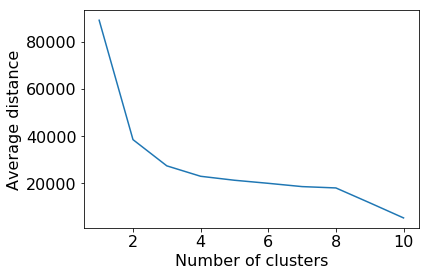

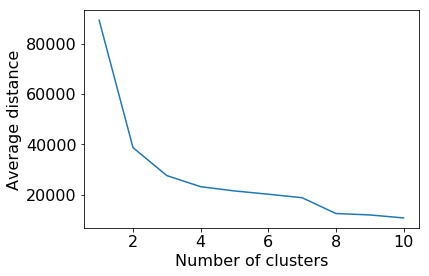

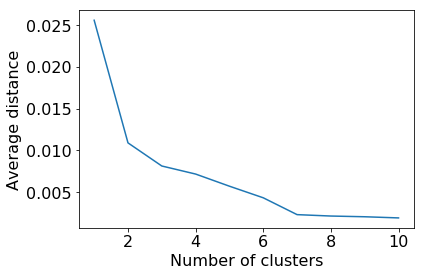

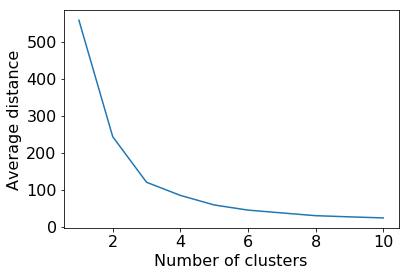

In [6]:
find_k_graph(10, kddDF[['src_bytes', 'count']], "DoS")
find_k_graph(10, kddDF[['duration','src_bytes']], "Probing")
find_k_graph(10, kddDF[['num_file_creations', 'num_shells']], "U2R")
find_k_graph(10, kddDF[['duration', 'num_failed_logins']], "R2L")

<u><strong>Performing K-mean<strong></u>

[212.7037037   22.07407407]
[3.065e+03 1.000e+00]
[1.591e+03 1.000e+00]


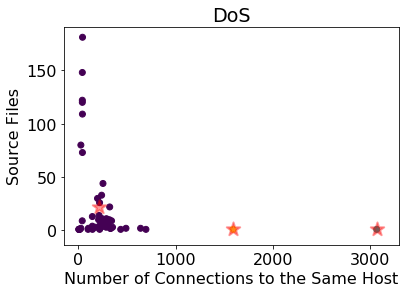

In [68]:
k_mean(3, kddDF[['src_bytes','count']][:100], xLabel="Number of Connections to the Same Host", yLabel="Source Files" ,title="DoS")

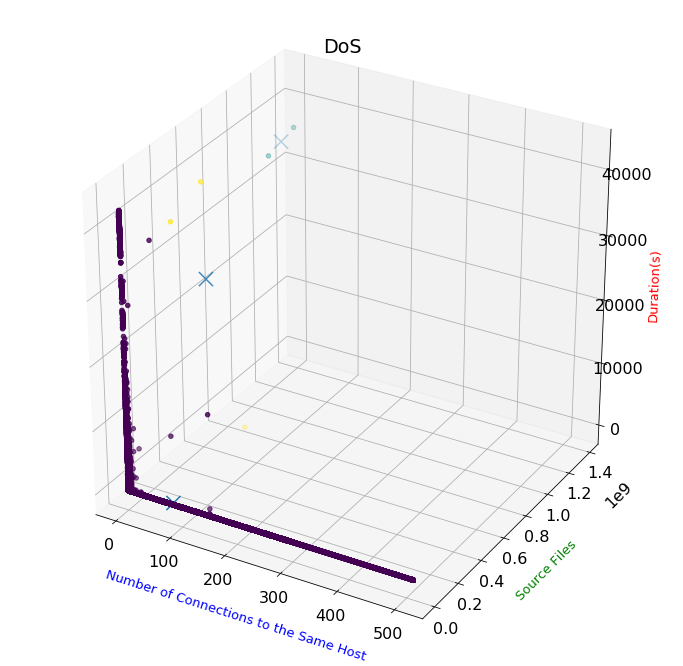

In [60]:
k_mean3D(3, kddDF[["count", "src_bytes", "duration"]], "DoS", xLabel="Number of Connections to the Same Host", yLabel="Source Files", zLabel="Duration(s)")

[  3598.11055628 132392.52371916]
[3.53245000e+04 1.27374169e+09]
[2.46476667e+04 5.65551131e+08]


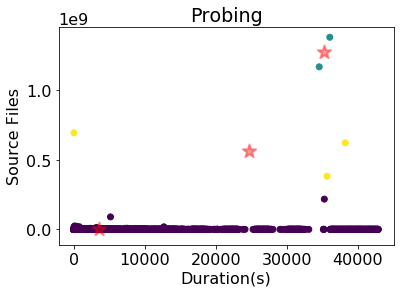

In [61]:
k_mean(3, kddDF[["duration","src_bytes"]], "Probing", xLabel="Duration(s)", yLabel="Source Files", NonZero=["duration"])

[0.0027243  0.00041301]
[ 3.04500000e+01 -5.42101086e-20]
[ 1.31428571e+01 -3.79470760e-19]


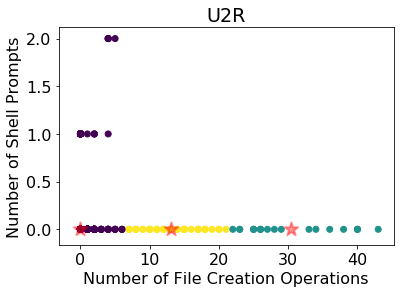

In [64]:
k_mean(3, kddDF[['num_file_creations', 'num_shells']], title="U2R", xLabel="Number of File Creation Operations", yLabel="Number of Shell Prompts", NonZero=[])

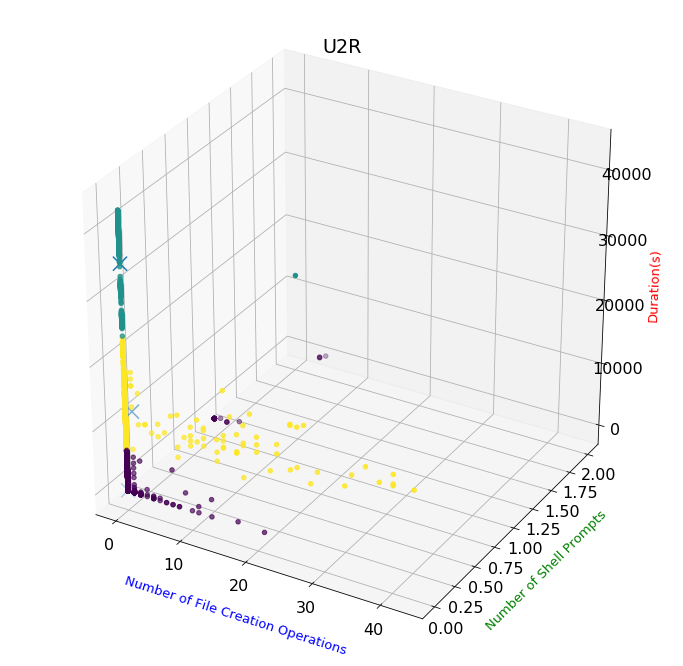

In [66]:
k_mean3D(3,  kddDF[['num_file_creations', 'num_shells', 'duration']], title="U2R", xLabel="Number of File Creation Operations", yLabel="Number of Shell Prompts", zLabel='Duration(s)')

[6.96100000e+03 1.77777778e+00]
[253.01694915   1.37288136]
[1.66716667e+04 1.00000000e+00]


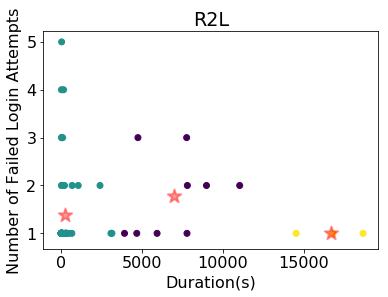

In [67]:
k_mean(3, kddDF[['duration', 'num_failed_logins']], title="R2L", xLabel="Duration(s)", yLabel="Number of Failed Login Attempts")

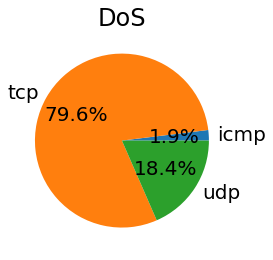

In [60]:
k_nn(kddDF[['src_bytes','count', 'protocol_type', 'class']], "protocol_type", "DoS")

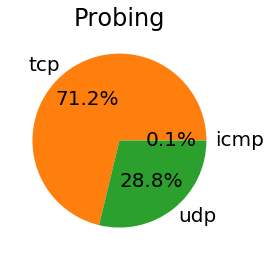

In [61]:
k_nn(kddDF[["duration","src_bytes", 'protocol_type', 'class']], "protocol_type", "Probing")

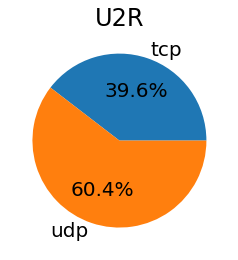

In [62]:
k_nn(kddDF[['logged_in', 'is_host_login', 'protocol_type', 'class']], "protocol_type", "U2R")

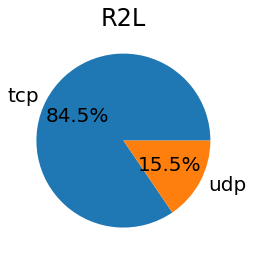

In [63]:
k_nn(kddDF[['duration', 'num_failed_logins', 'protocol_type', 'class']], "protocol_type", "R2L")

In [48]:
kddDF[['logged_in', 'root_shell', 'num_root', 'class']][(kddDF['logged_in']!="0")&(kddDF['num_root']!=0)&(kddDF['class']!='normal')].dropna()

,logged_in,hot,num_root,class
3005,1,15.0,54.0,anomaly
3173,1,1.0,14.0,anomaly
11448,1,0.0,7.0,anomaly
25095,1,0.0,4.0,anomaly
36730,1,1.0,1.0,anomaly
37270,1,0.0,4.0,anomaly
47343,1,0.0,1.0,anomaly
59000,1,0.0,1.0,anomaly
66007,1,0.0,2.0,anomaly
69147,1,0.0,2.0,anomaly


<u><strong>Swarm Plot</strong></u>

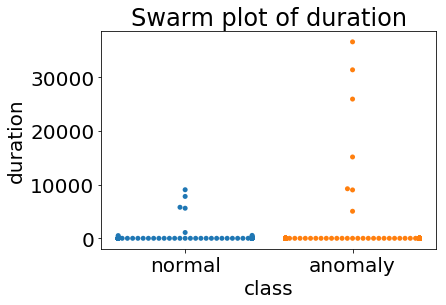

In [43]:
swarm_all(kddDF[['duration','class']][:500], "class", "Swarm plot of duration")

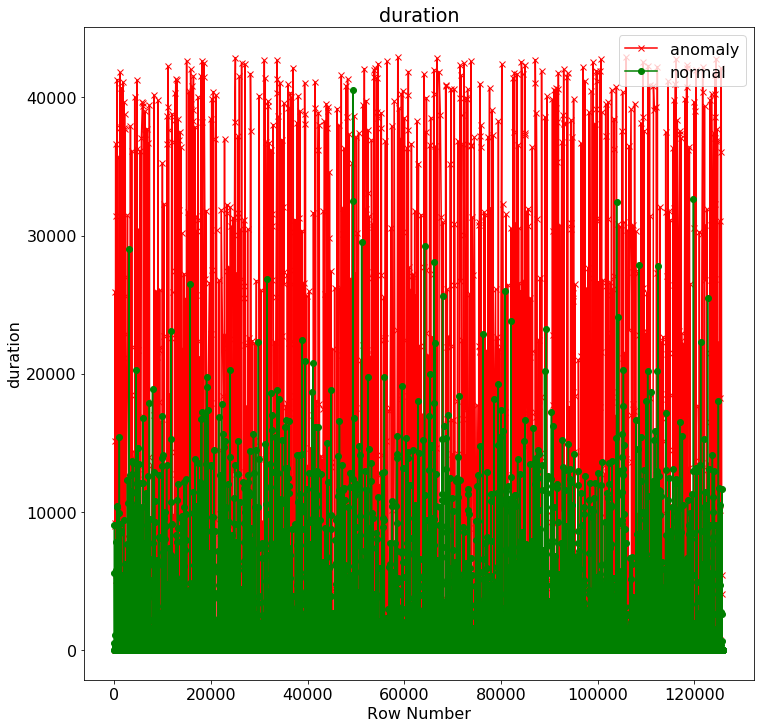

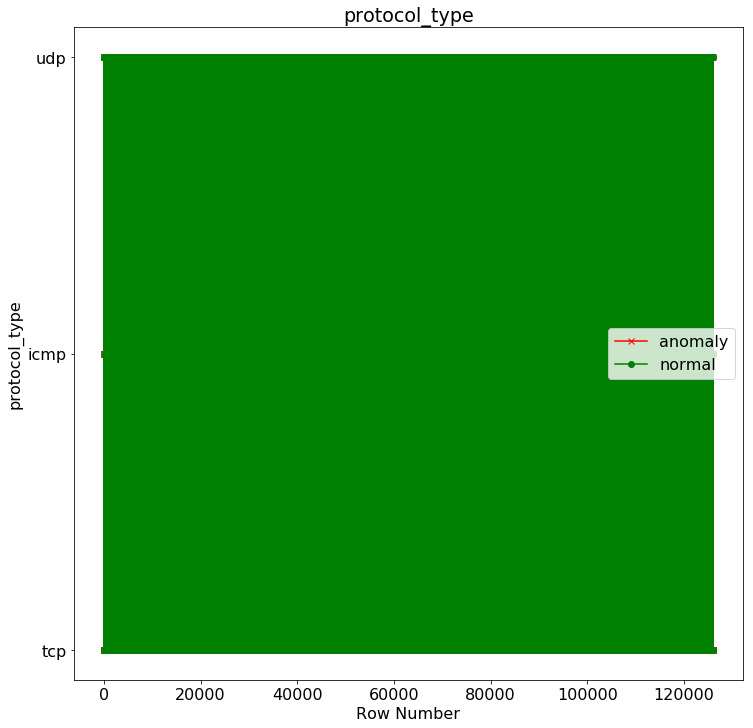

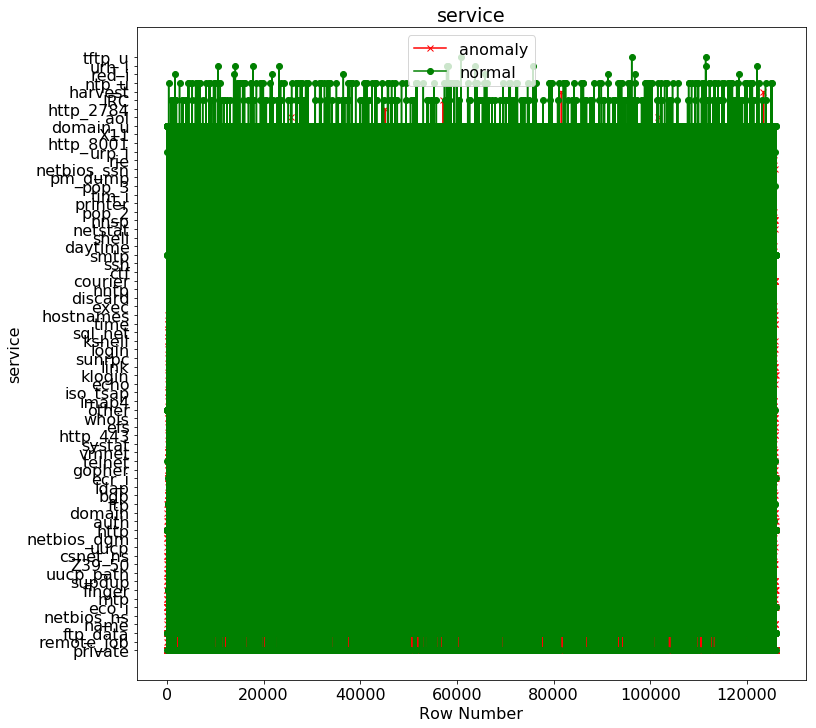

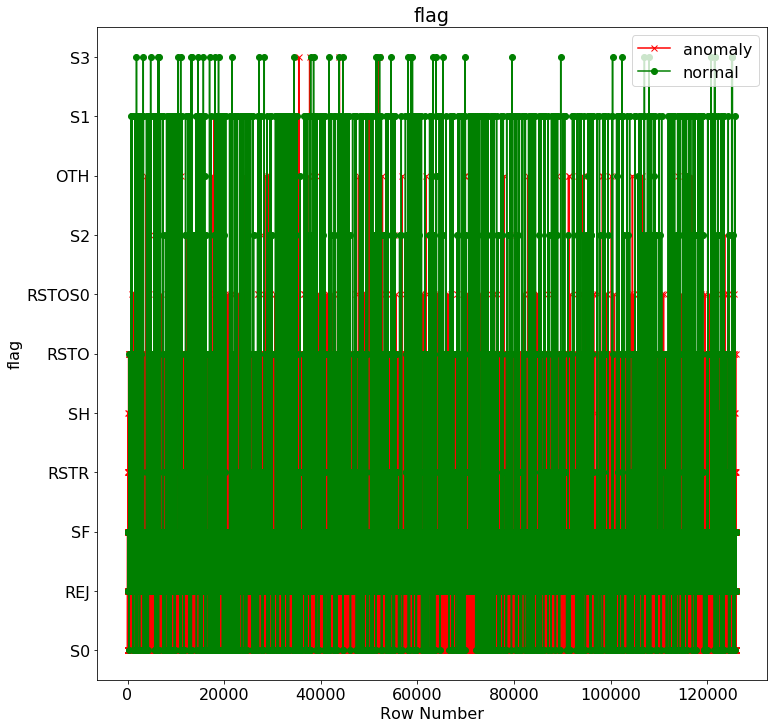

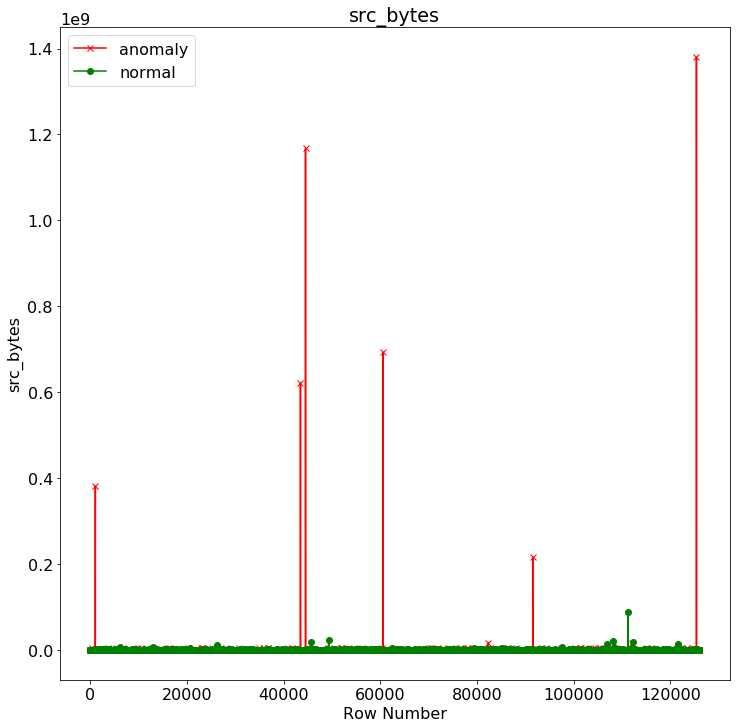

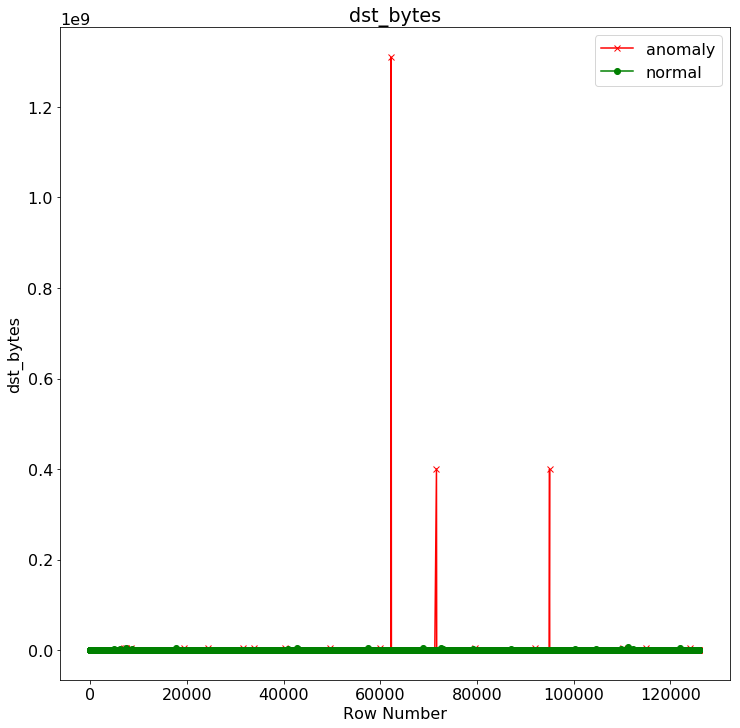

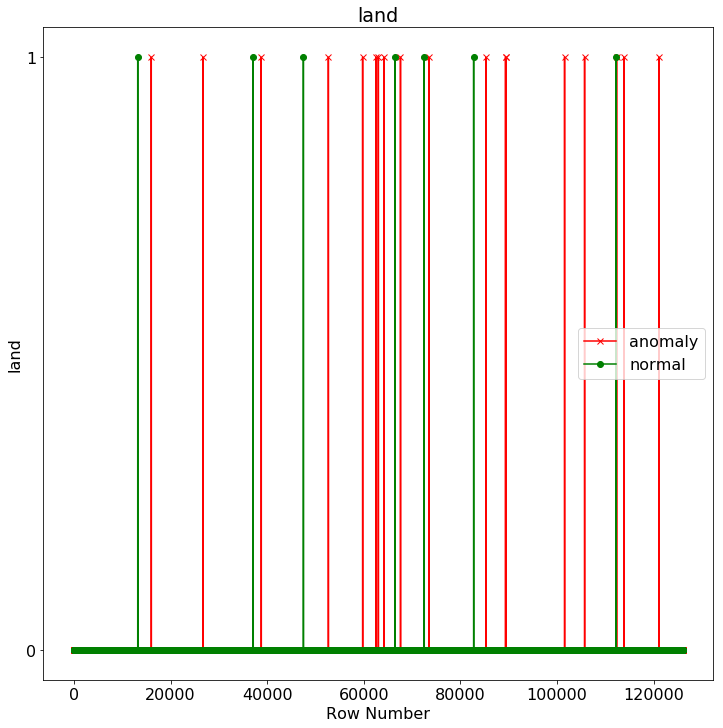

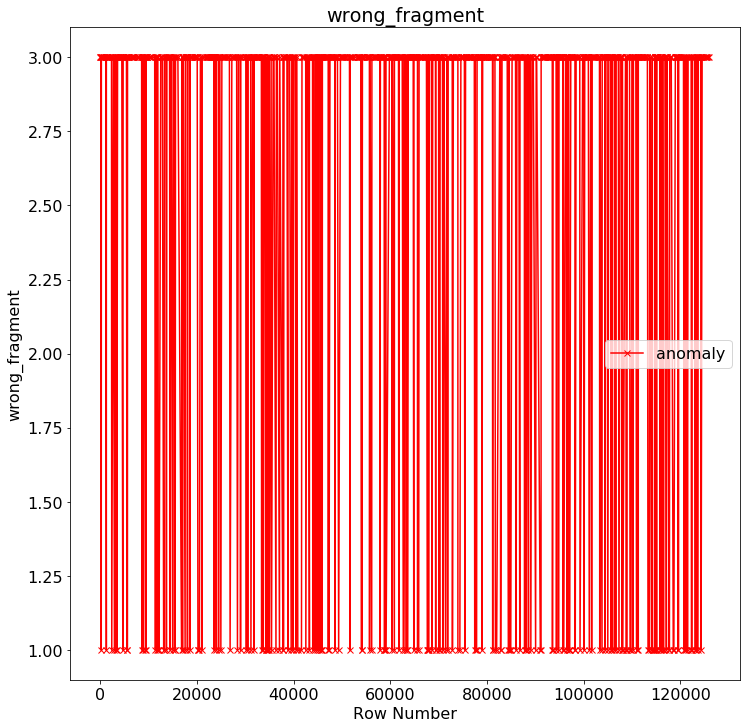

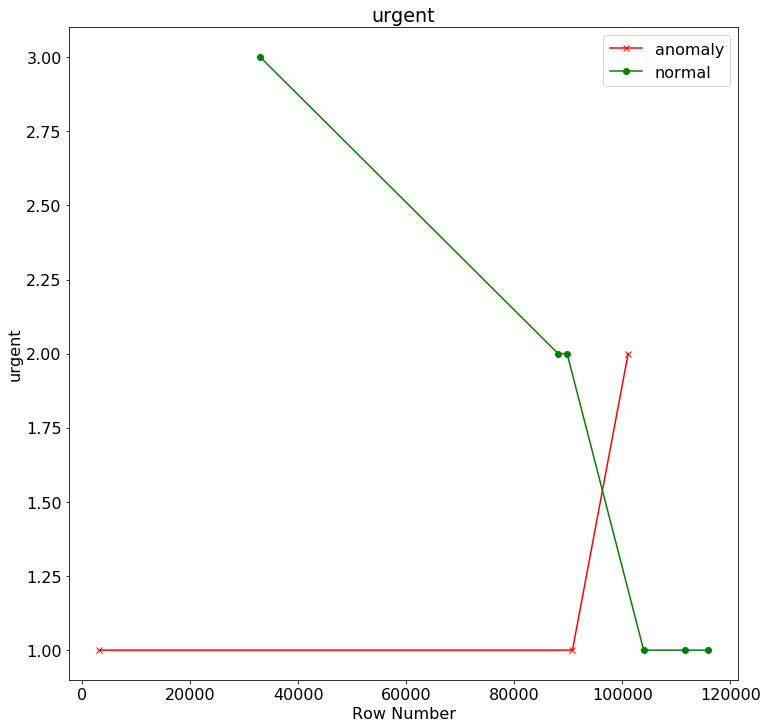

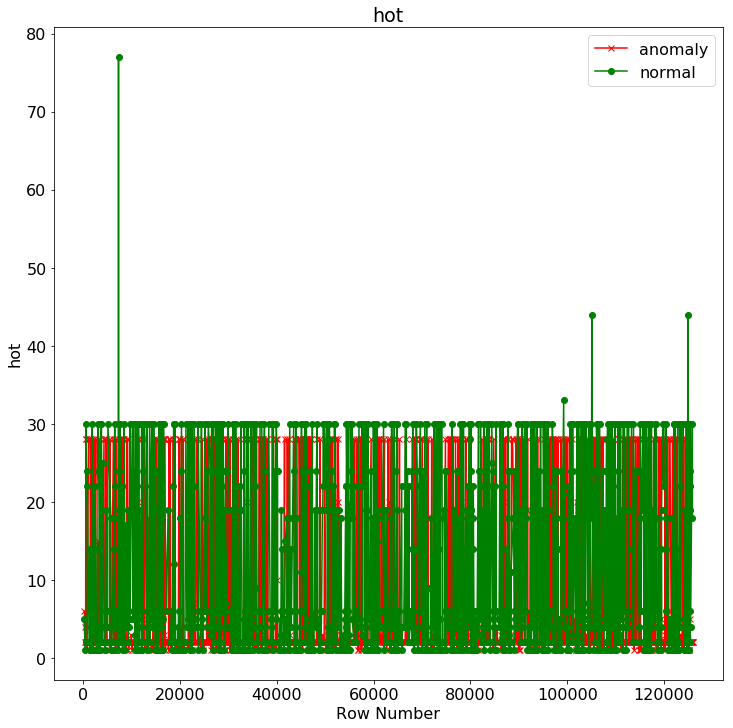

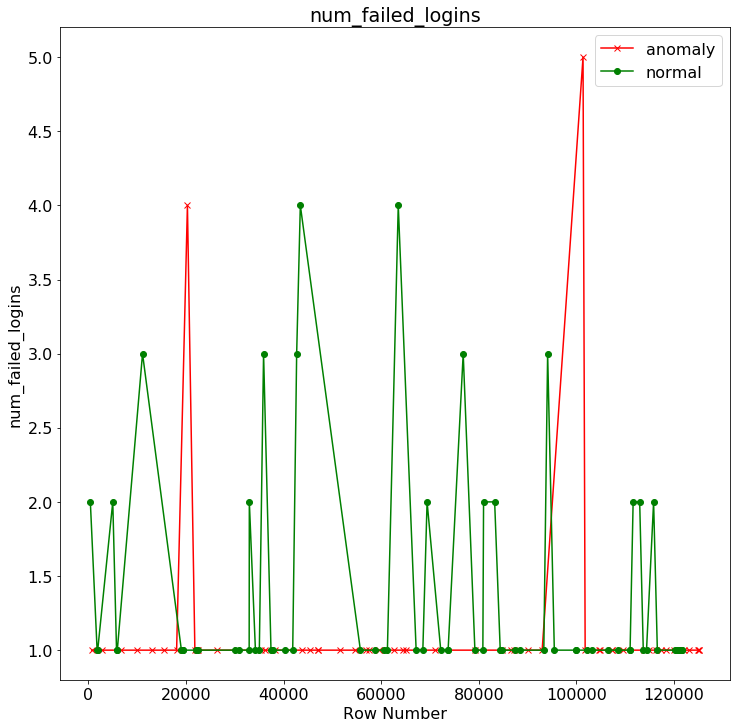

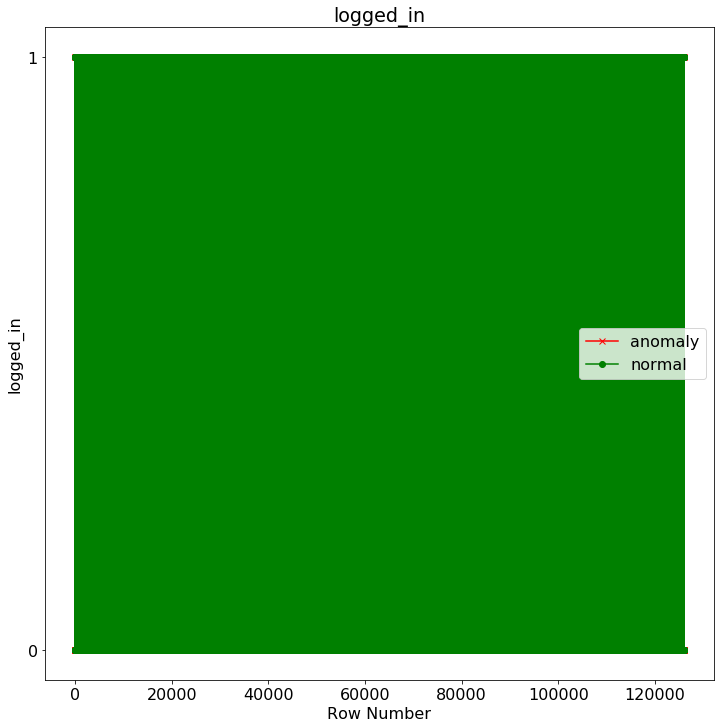

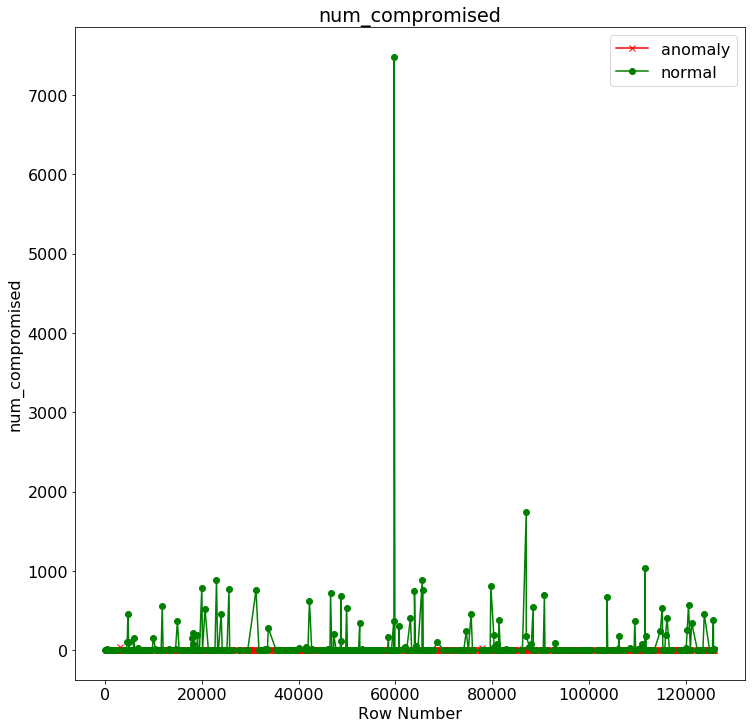

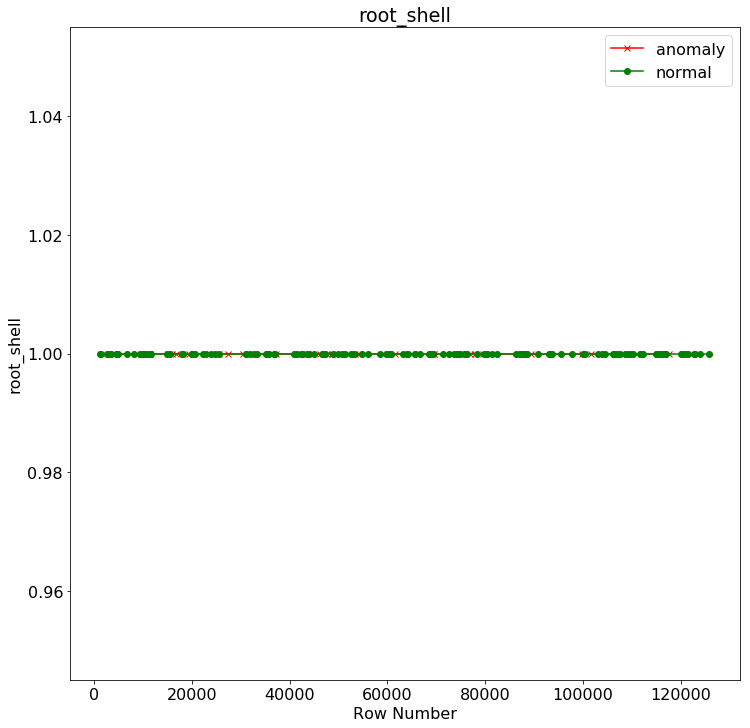

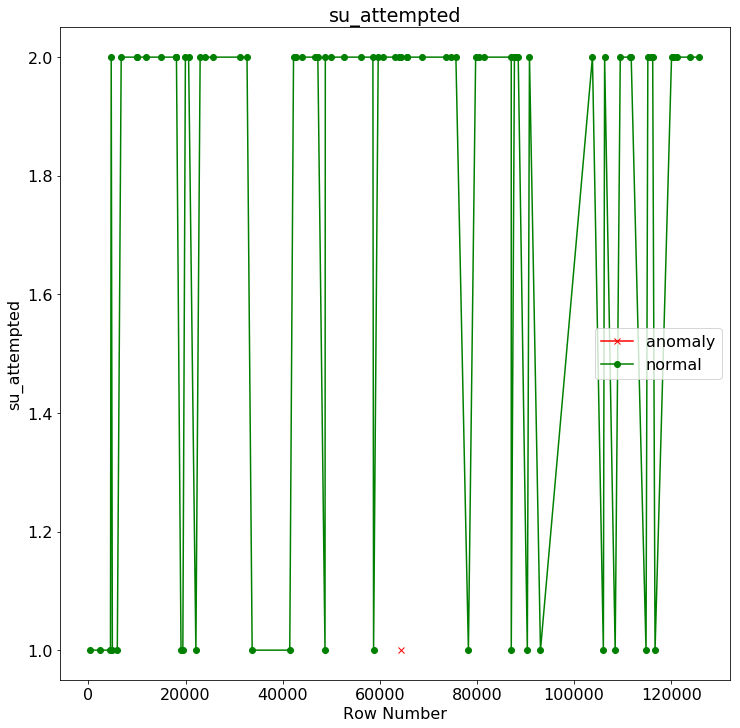

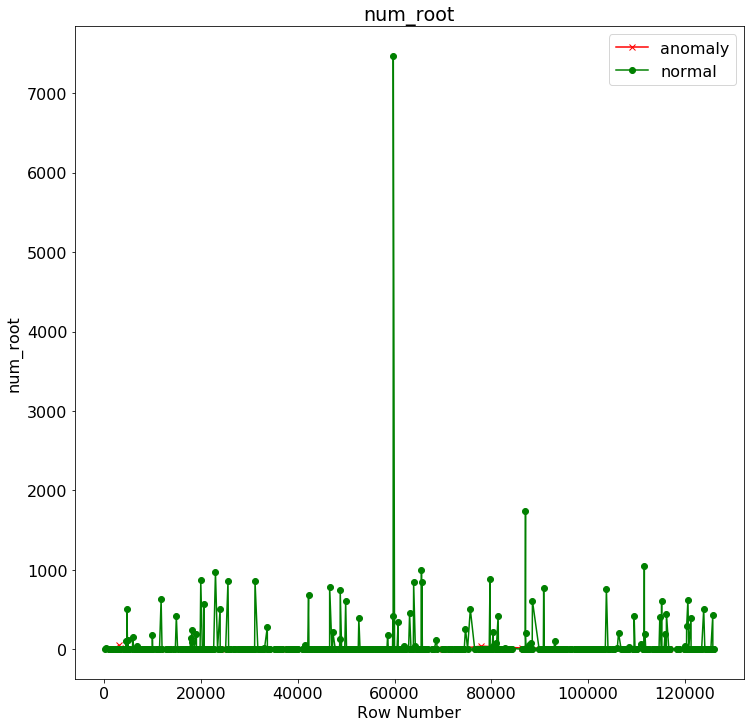

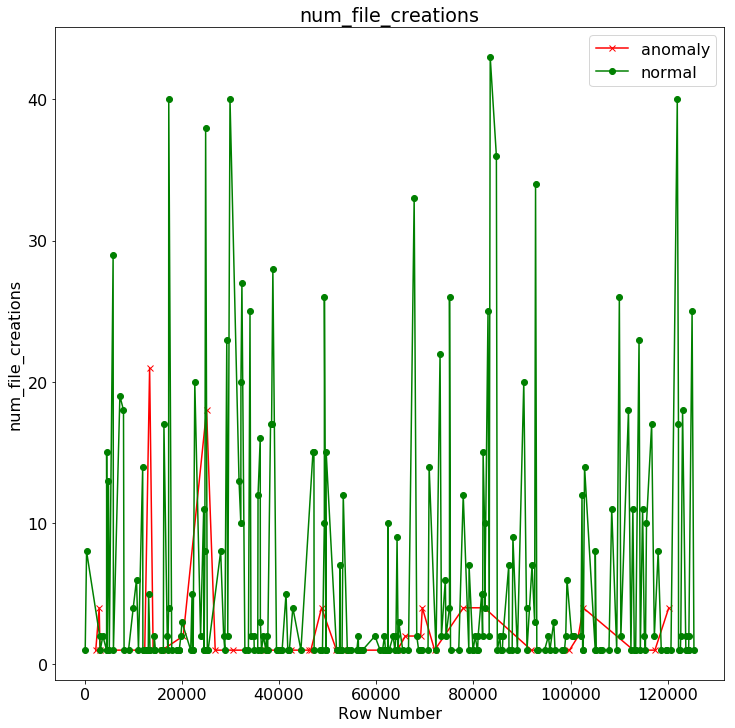

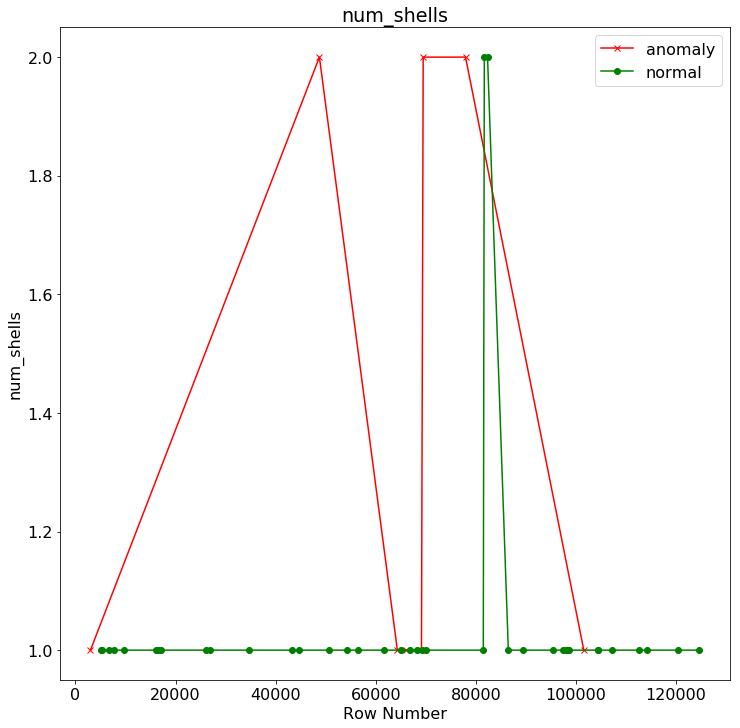

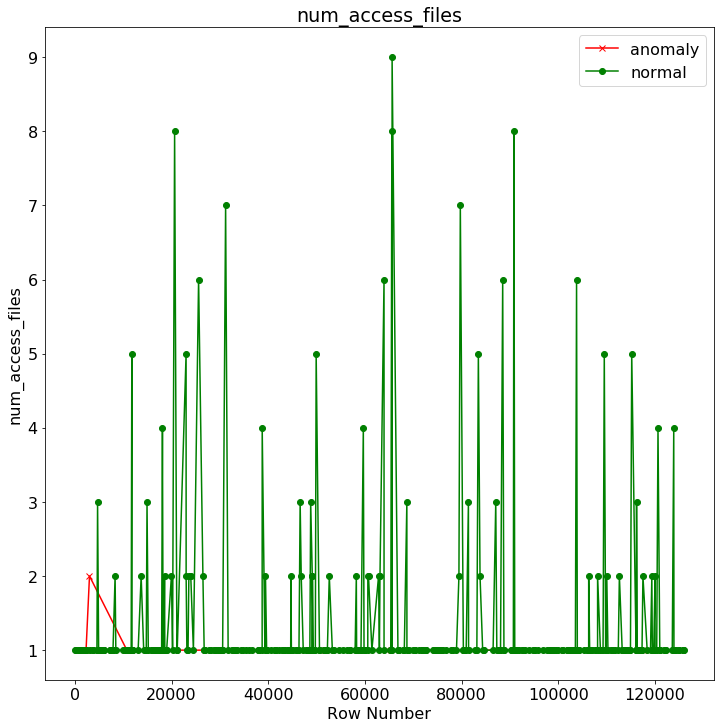

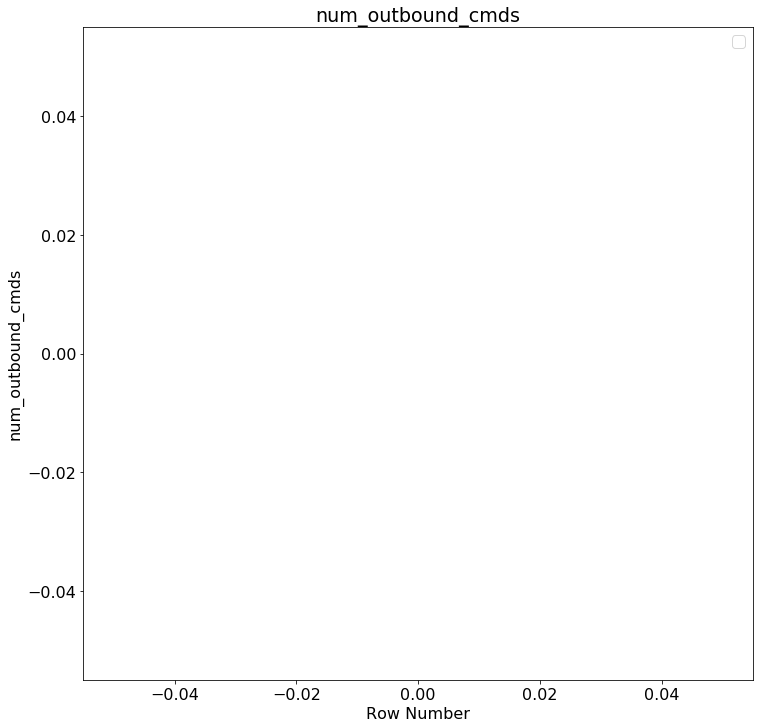

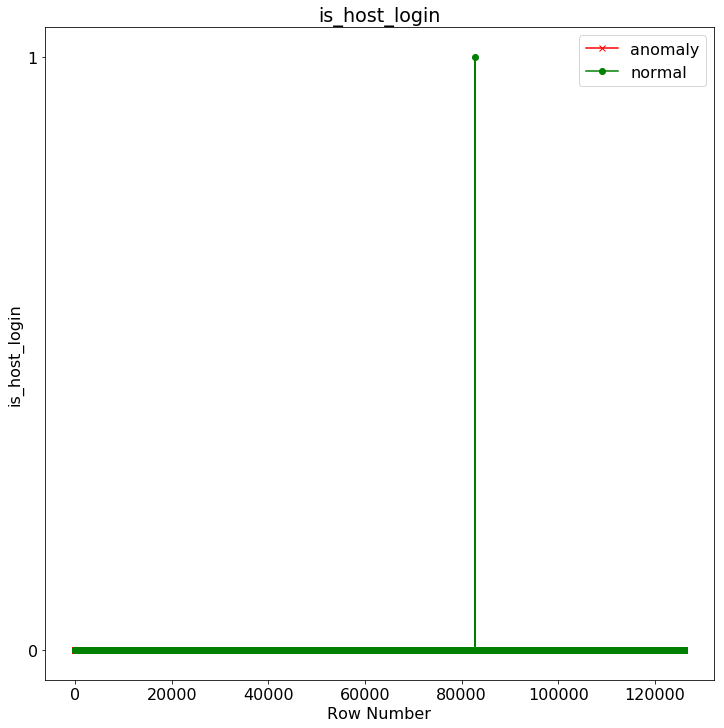

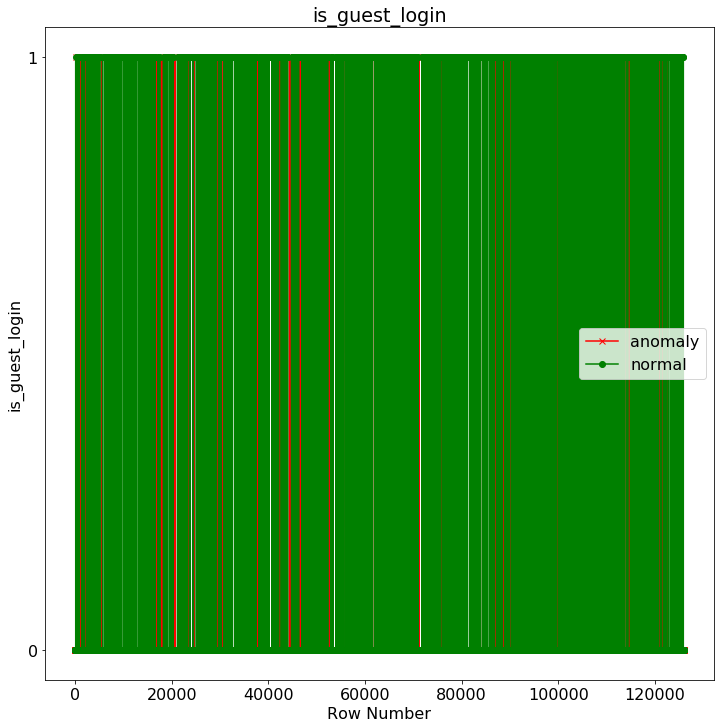

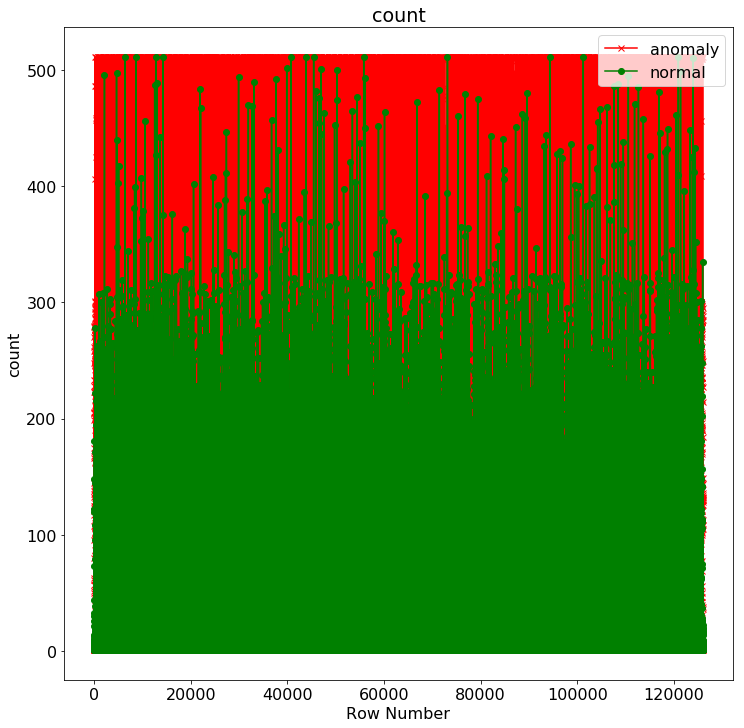

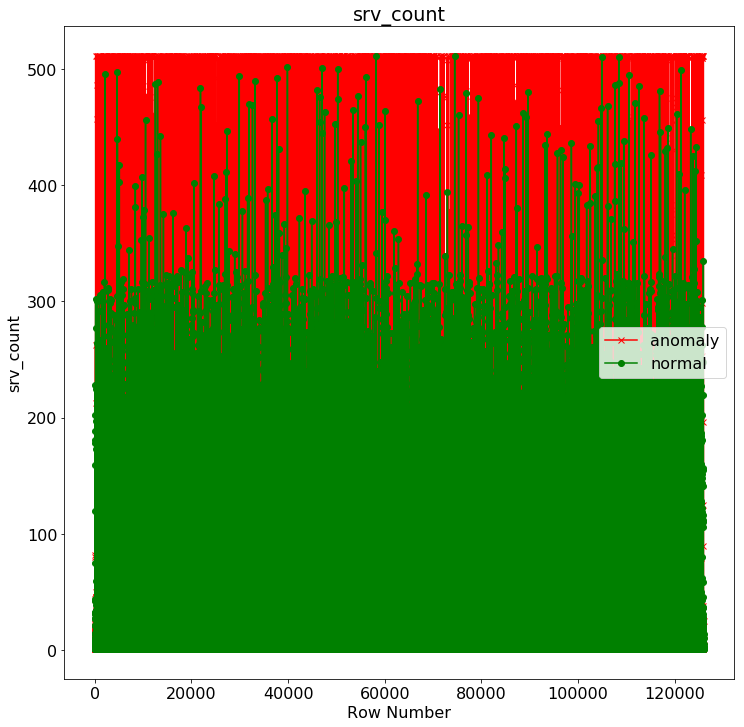

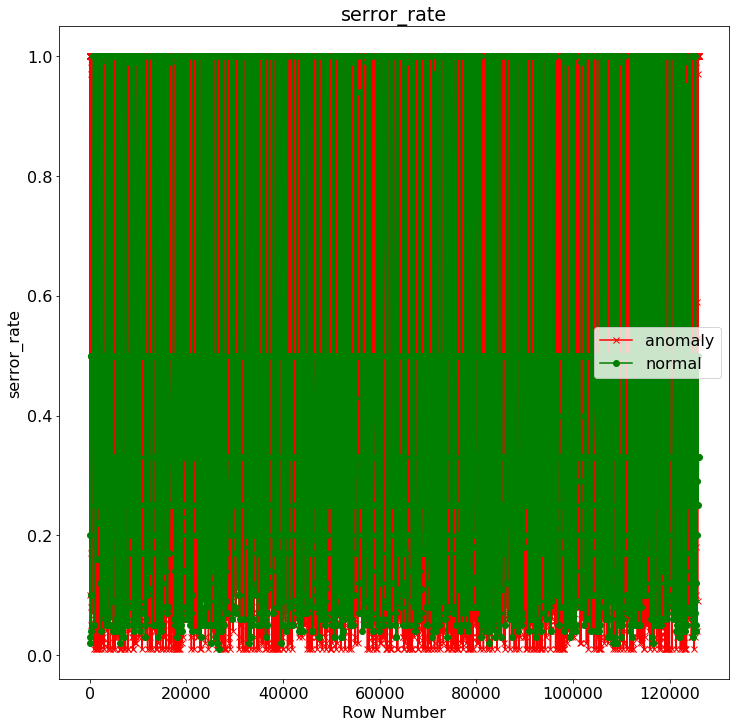

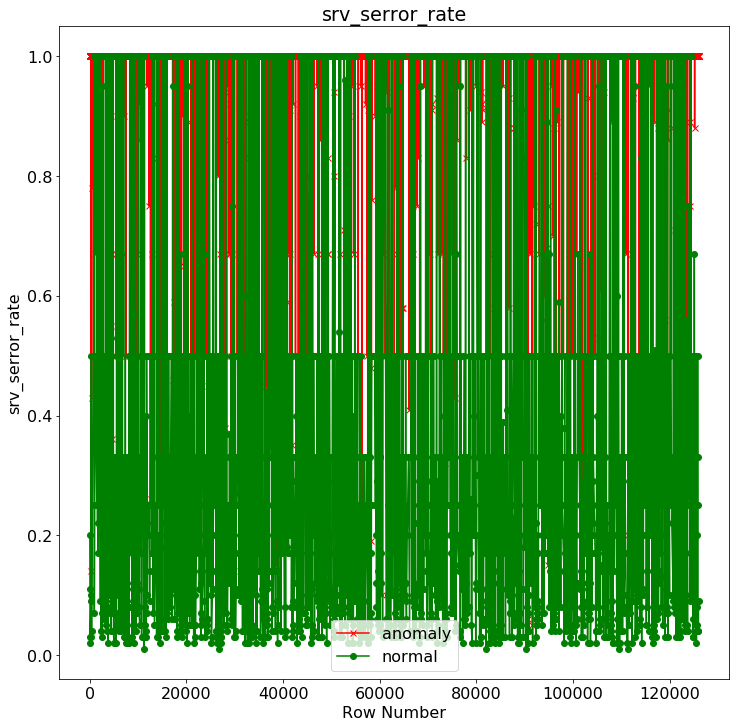

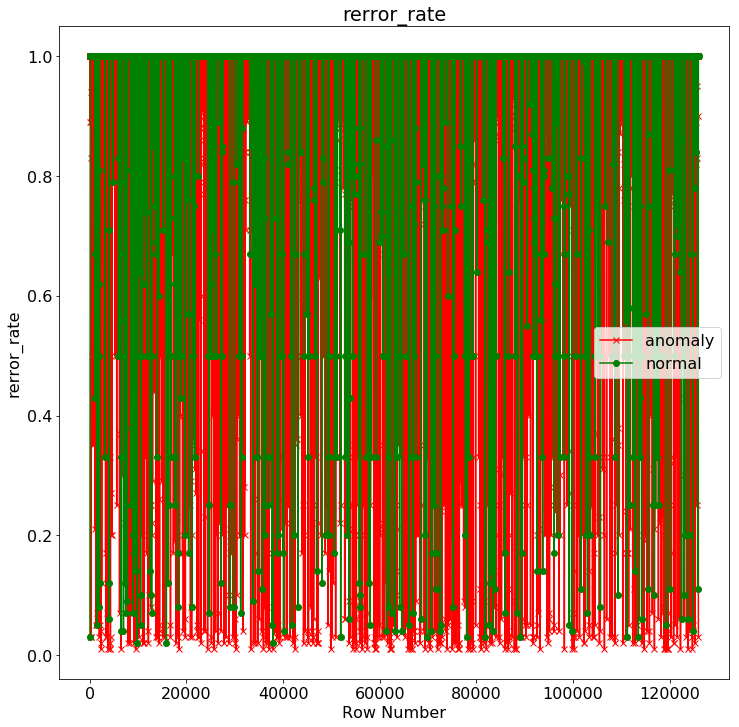

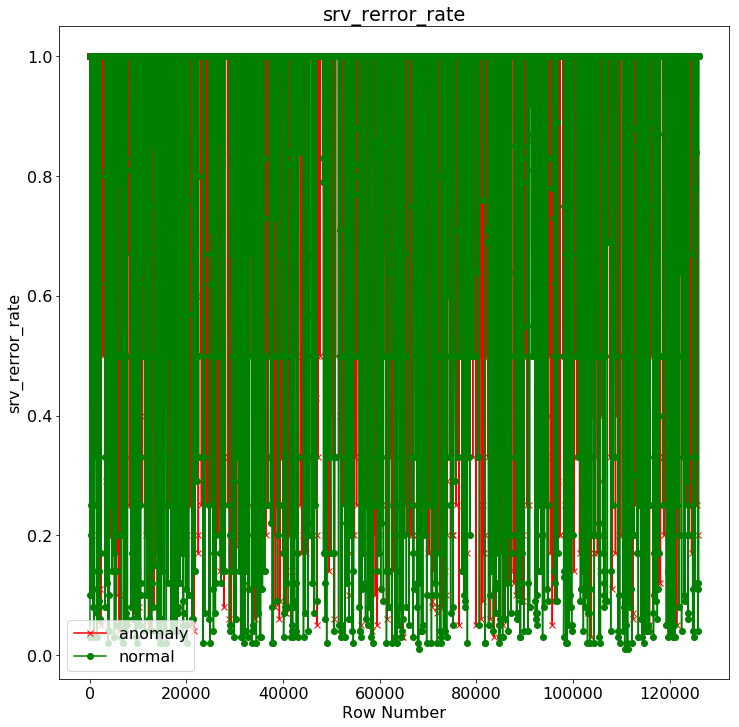

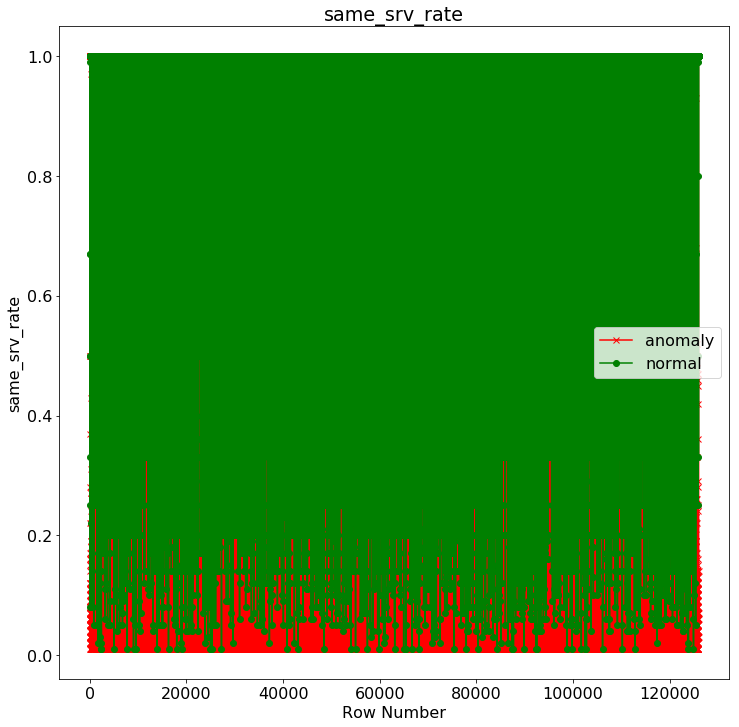

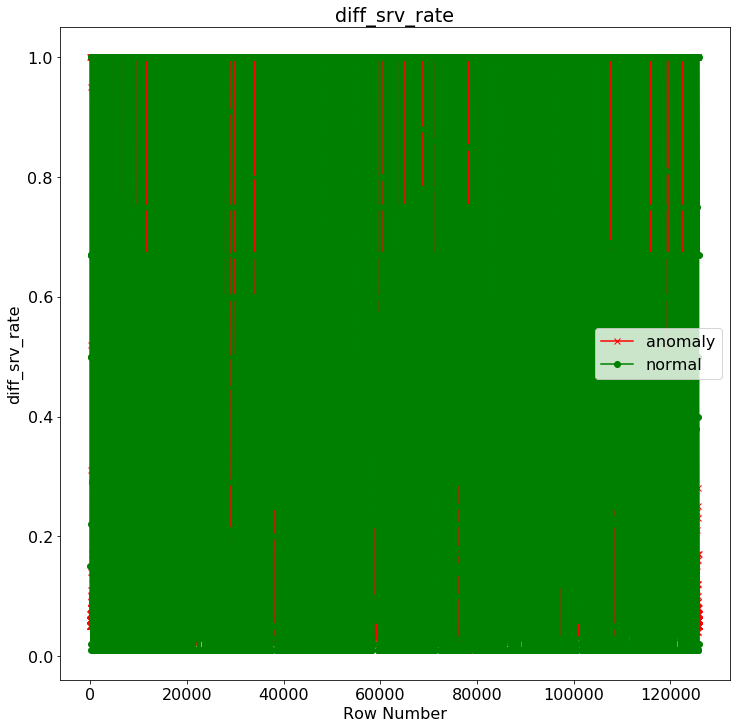

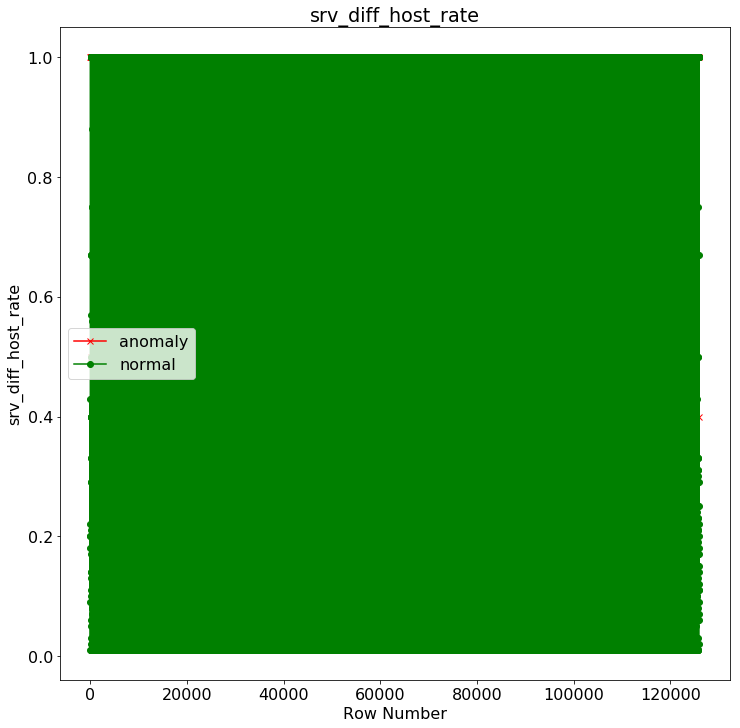

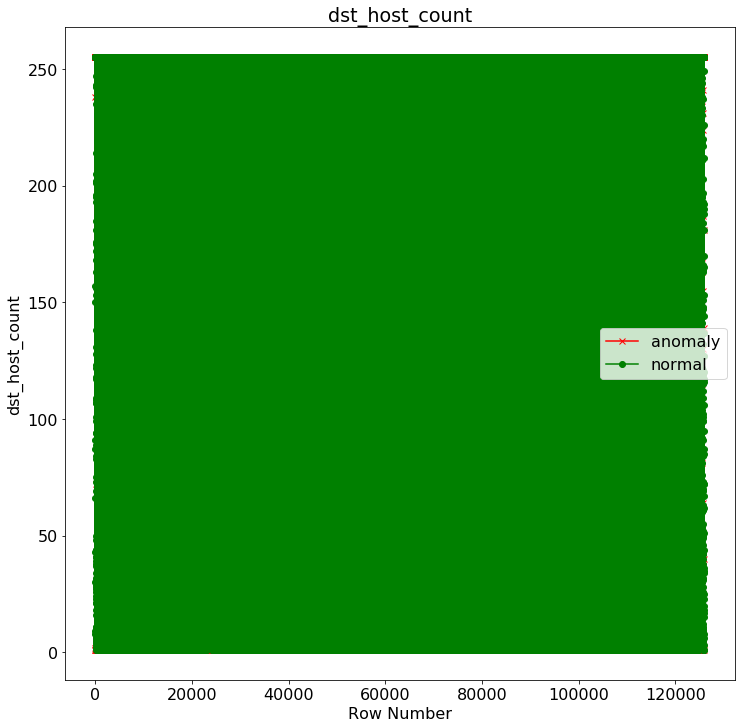

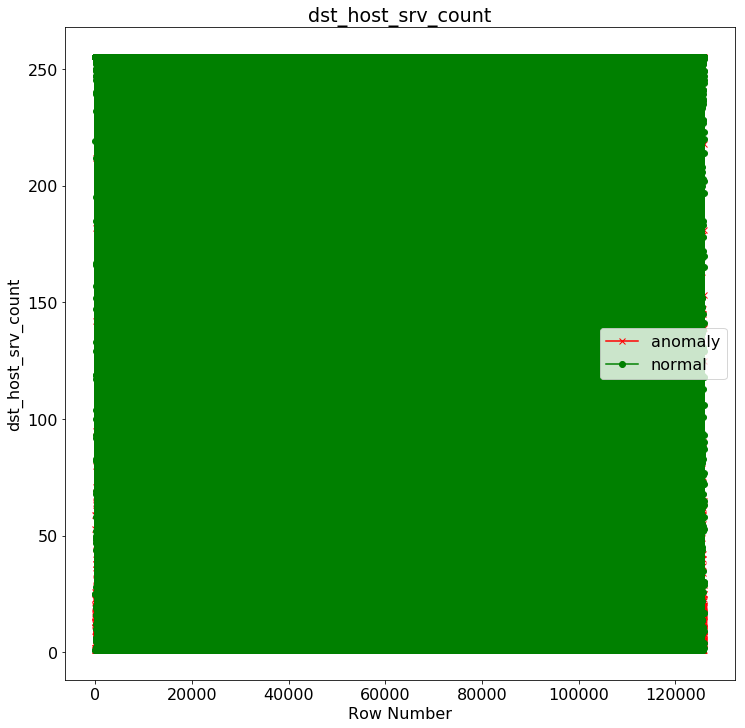

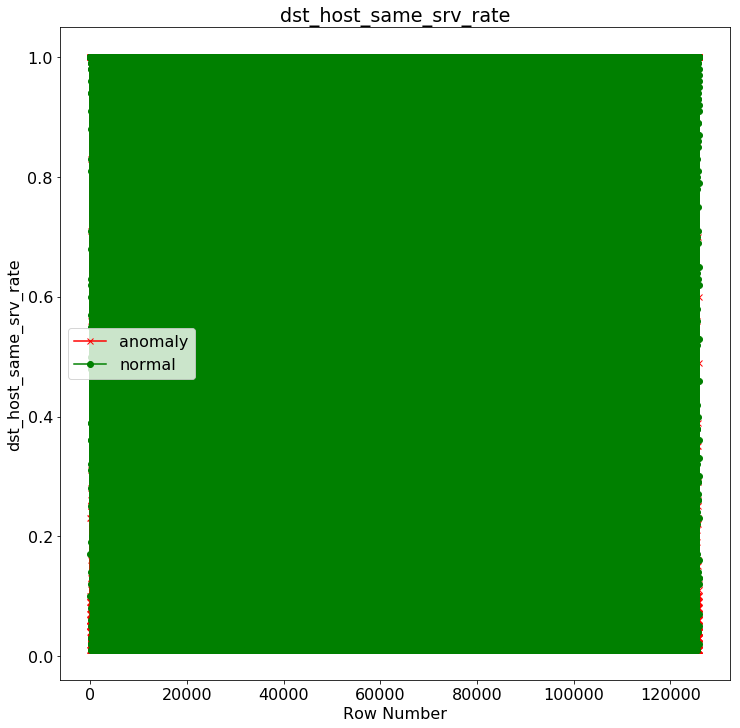

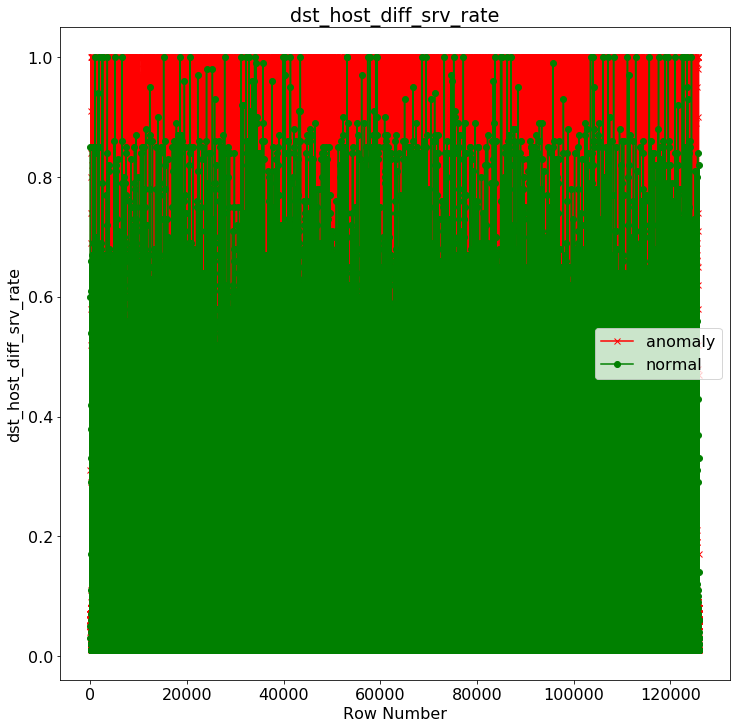

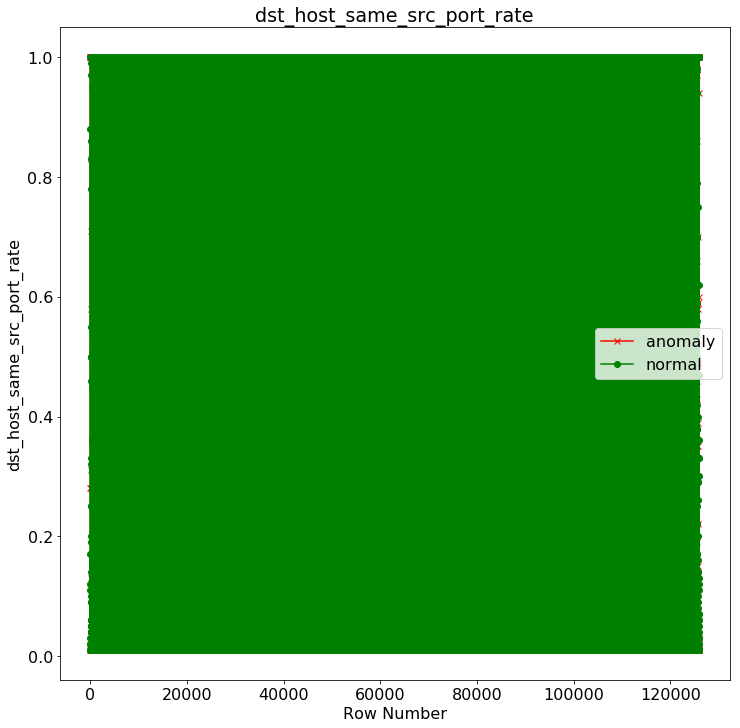

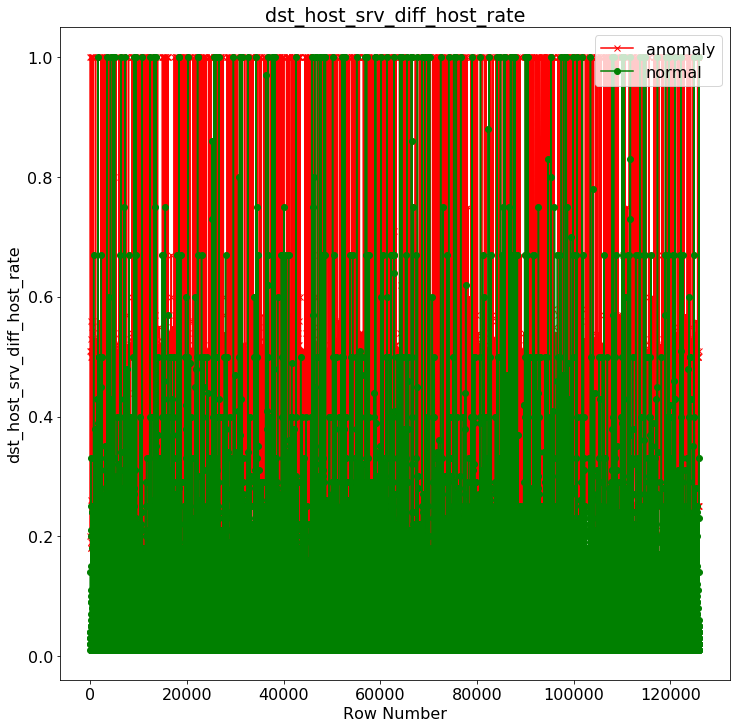

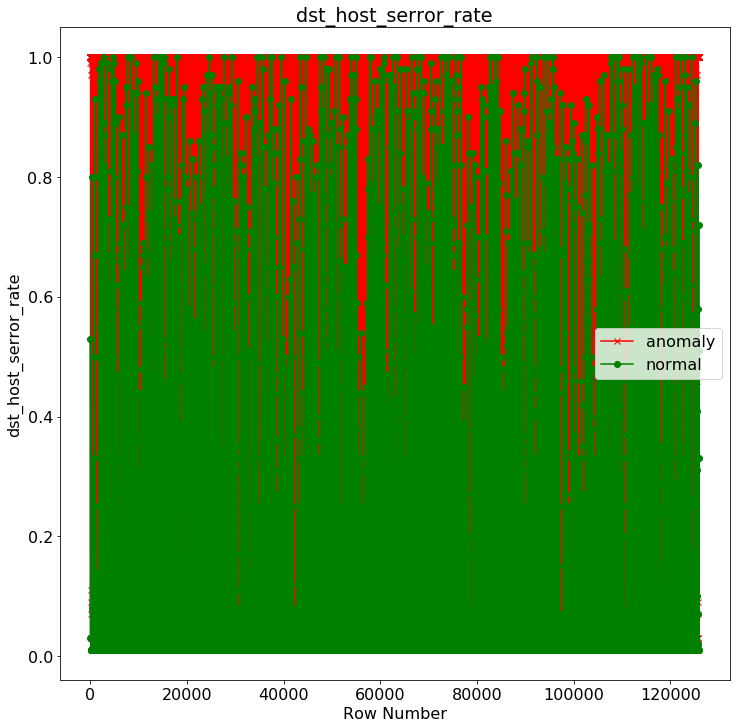

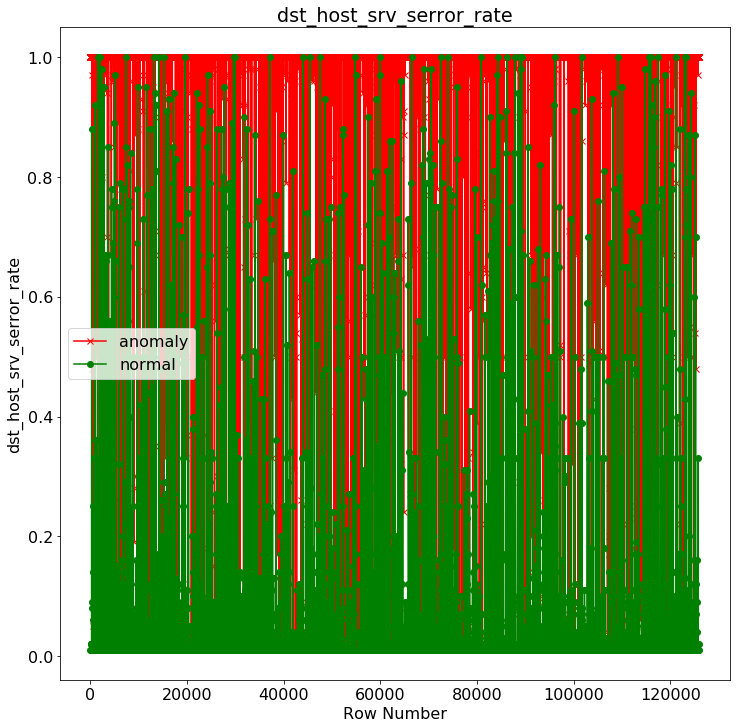

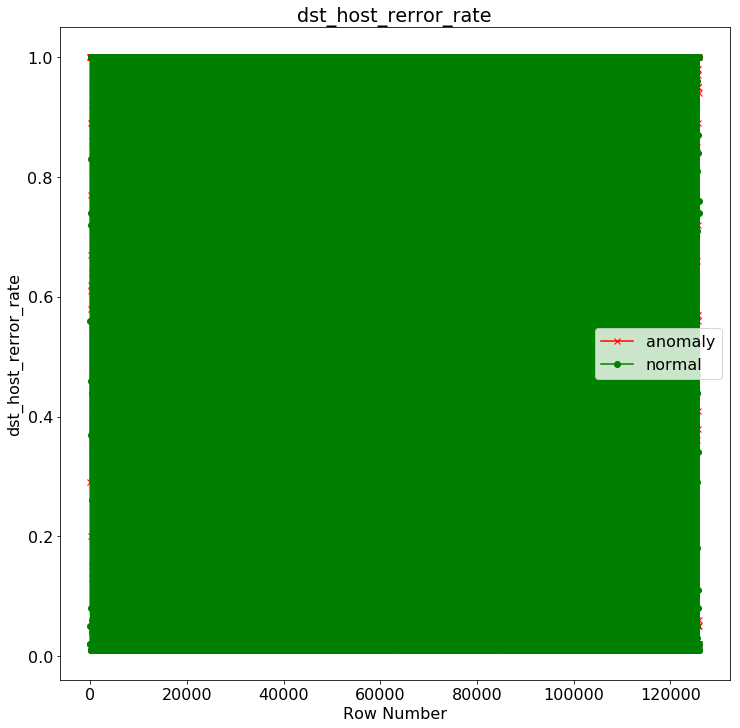

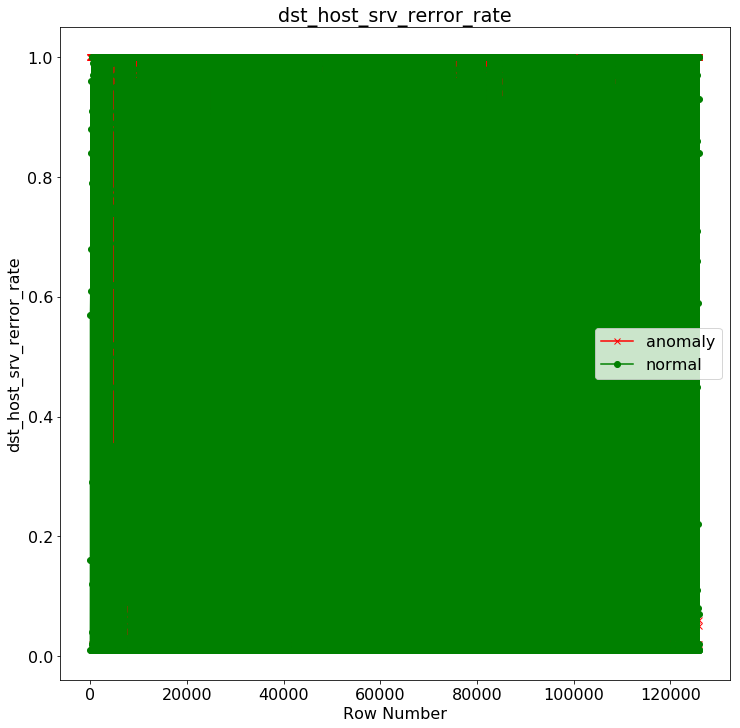

In [79]:
for i in kddDF.columns:
    plot_all(kddDF[[i, 'class']][:], "class", i)

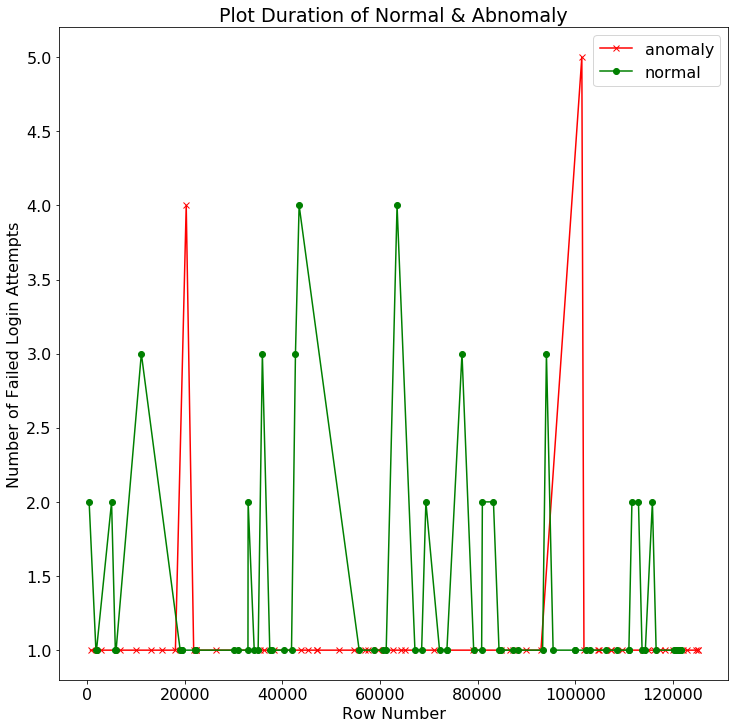

In [74]:
plot_all(kddDF[['num_failed_logins','class']], "class", "Plot Duration of Normal & Abnomaly", yLabel="Number of Failed Login Attempts")

# CIDDS Dataset

<u><strong>Load CIDDS Dataset</strong></u>

In [ ]:
#ciddsDF = pd.read_csv("CIDDS-001-internal-week1.csv", low_memory=False)
#ciddsDF.head()

In [ ]:
feats = ["Src Pt", "Dst Pt", "Packets", "Flows"]

In [ ]:
#find_k_graph(5, ciddsDF[["Src Pt", "Packets"]])

<u><strong>Performing K-mean</strong></u>

In [ ]:
#k_mean(2, ciddsDF[["Src Pt", "Packets"]], "DoS")

In [ ]:
#k_mean(4, ciddsDF[["Src Pt", "Packets"]], "K-Mean cluster on CIDDS Dataset")

In [ ]:
#k_nn(ciddsDF[['Src Pt','Packets', 'class']], "Src Pt", "class", "DoS")

In [ ]:
#swarm_all(ciddsDF[['duration', 'Src Pt', 'Dest Pt', 'Packets', 'Bytes', 'Flows', 'Tos' 'class']][:500], "Class", "Swarm plot of duration")